# Lab 2 - bandit recommendations

## Lab preparation

 * [optional] Create python virtual enviroment
 `python3 -m venv ./recsyslab2`
 * install libs:
 `pip3 install matplotlib`
 * include `bandit_framework.py` in the same directory

## Część 1. - framework i naiwni bandyci

In [13]:
# import all needed packages

from copy import copy
from math import log, sqrt
from itertools import product
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # test enviroment

In [14]:
# test parameters

runs = 50
epochs = 100
recommendation_size = 10

In [15]:
# initializing arms - payout for each arm(product that can be recommended) will be represented by a constant value (1)
# arms represent CTR, clickthrough rate - probability of click p and constant payout after click
# these arms simulate real products (for example movies) that users can choose
# We'll use them to create bandit simulation - bandits will learn to recommend the good arms

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in good_arms+bad_arms}
arm_ids = list(arms.keys())

In [16]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.777152999978212


In [17]:
# random recommendations - useful as a reference model
# we don't want our bandits to be worse than random recommendations

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [18]:
# Perfect bandit - knows how each arm works - it knows the future (probability of clicking on a recommendation)
# useful for comparison with our trained bandits

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # bruteforce search for the expected value
        return sum([payout_function() for i in range(n)]) / n

In [19]:
# list of bandits that we want to compare

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [20]:
# creating a test (Runner class)

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 579.7600000000001
random: 280.99999999999994


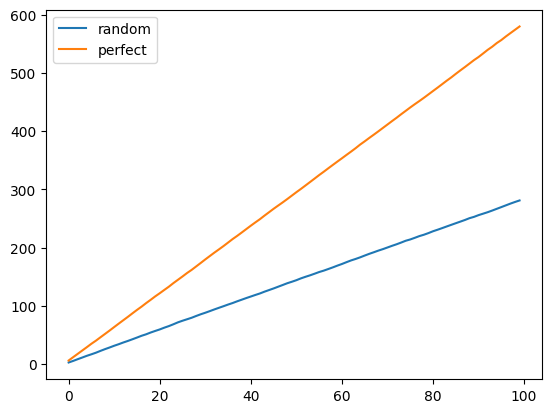

In [21]:
# summary of results for all runner epochs

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.7
random: 2.62


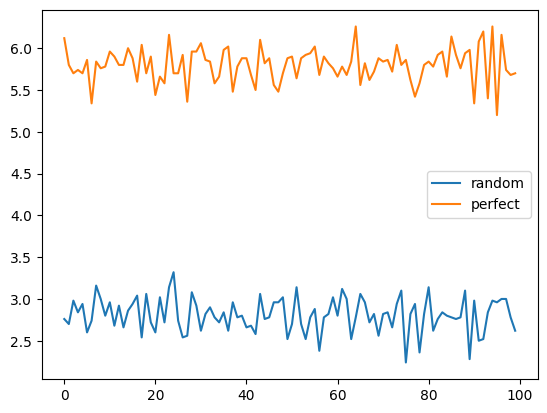

In [22]:
# scores in each epoch

runner.plot_results(results, runs, epochs, mode='average')

## Part 2 - target bandit models

In [28]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        arm_ids_sorted = [x[0] for x in sorted(self.payouts_per_recommendation.items(), key=lambda x: x[1], reverse=True)]
        arm_list = list(self.arm_ids)
        shuffle(arm_list)
        to_recommend = [arm_ids_sorted[i] if (random() > self.epsilon) else arm_list[i] for i in range(size)]
        for arm_id in to_recommend: self.recommended_rates[arm_id] += 1
        return to_recommend
        
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [37]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 1 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 1
    
    def recommend(self, size):
        optimistic_function = {arm_id: self.payouts_per_recommendation[arm_id] + self._optimism(arm_id) for arm_id in arm_ids}
        to_recommend = [x[0] for x in sorted(optimistic_function.items(), key=lambda x: x[1], reverse=True)][:size]
        for arm_id in to_recommend: self.recommended_rates[arm_id] += 1
        self.n += size # or 1? or what? when do I update this?
        return to_recommend
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        if self.recommended_rates[arm] == 0:
            return 1.0
        return self.optimism_weight * sqrt(log(self.n) / self.recommended_rates[arm])

In [42]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        random_values = {arm_id : betavariate(self.a[arm_id],self.b[arm_id]) for arm_id in arm_ids}
        to_recommend = [x[0] for x in sorted(random_values.items(), key=lambda x: x[1], reverse=True)][:size]
        return to_recommend
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1-payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Part 3 - rough bandit comparison

In [43]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [44]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

perfect: 5.98
ts_1_20: 5.84
ts_1_5: 5.78
ts_1_1: 5.68
ts_5_5: 5.68
ts_5_10: 5.62
ts_20_1: 5.56
ts_1_50: 5.52
ts_5_1: 5.52
ts_1_10: 5.5
ts_10_1: 5.5
ts_50_1: 5.42
egreedy_0.05: 5.34
ucb_1: 5.3
ts_5_20: 5.28
ts_20_50: 5.24
ts_50_5: 5.18
egreedy_0.1: 5.14
ts_5_50: 5.1
ts_20_5: 5.1
ts_50_50: 5.1
ts_10_5: 5.04
ts_10_50: 5.04
ucb_0.1: 4.96
ts_50_10: 4.92
ts_20_10: 4.9
ts_10_10: 4.84
ts_10_20: 4.8
ts_50_20: 4.66
ts_20_20: 4.64
egreedy_0.25: 4.48
egreedy_0.01: 4.26
ucb_10: 3.12
random: 2.88
ucb_0.01: 2.78


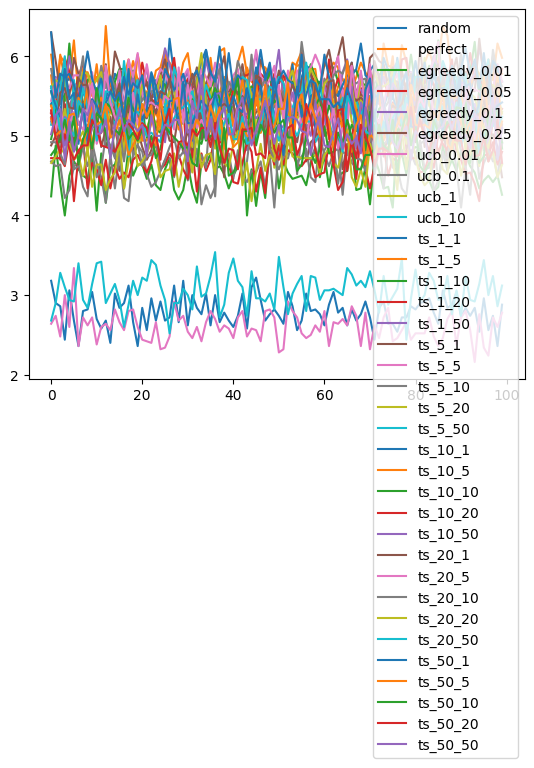

In [45]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 578.6
ts_10_1: 569.4800000000001
ts_5_1: 568.5799999999999
ts_5_5: 565.8799999999999
ts_1_5: 562.98
ts_1_20: 562.9199999999998
ts_1_50: 561.02
ts_1_10: 560.4199999999997
ts_1_1: 557.8199999999997
ts_5_10: 557.1400000000001
ts_5_20: 550.7800000000001
ts_5_50: 547.8800000000002
ts_20_1: 540.88
ts_50_1: 539.74
egreedy_0.1: 535.3599999999999
ts_20_5: 529.0799999999999
ts_10_5: 527.3399999999998
ts_10_50: 525.28
egreedy_0.05: 522.6400000000001
ucb_1: 521.7999999999997
ts_10_10: 521.6199999999999
ts_20_50: 517.3
ts_50_5: 514.0599999999997
ts_50_50: 509.8599999999999
egreedy_0.25: 501.28
ts_50_10: 494.5199999999999
ts_50_20: 494.46000000000004
ts_20_10: 480.71999999999997
ts_20_20: 470.36000000000007
ts_10_20: 466.7000000000001
ucb_0.1: 461.81999999999977
egreedy_0.01: 453.3200000000001
ucb_10: 306.26000000000005
random: 279.0999999999999
ucb_0.01: 260.18000000000006


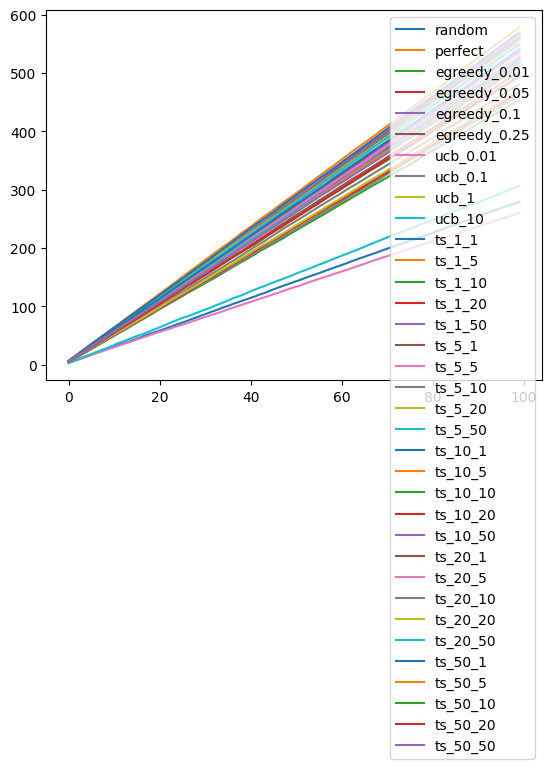

In [46]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Part 4 - precise bandit comparison

In [68]:
# returns all arms that are labelled as "good" in a list
def relevant(recommendation: List[Arm]) -> float:
    return len([r for r in recommendation if r.arm_id[:5] == "good_"])

all_relevant = relevant(arms.values())

In [79]:
# precision@k and recall@k
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    return relevant(recommendation[:k])/k

def recall_at_k(recommendation: List[Arm], k: int) -> float:
    all_relevant = relevant((recommendation))
    if all_relevant == 0: return 0.
    return relevant(recommendation[:k])/all_relevant

In [80]:
# checking if precision@k and recall@k works properly
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k)}') # removed all_relevant

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.42857142857142855


In [84]:
# bandits to test
testing_names = {'random','perfect','egreedy_0.1','ucb_1','ts_10_1'} 
testing_bandits = {b.bandit_id : b for b in bandits if b.bandit_id in testing_names}

# choosing values of k
k_vals = [3, 5, 10]

# number of recommendations
samples = 10

for bandit in testing_bandits.items():
    print(f"bandit : {bandit[0]}")
    recommendation_ids = bandit[1].recommend(samples)
    recommendation = [arms[arm_id] for arm_id in recommendation_ids]
    for k in k_vals:
        print(f"  precision at {k} : {precision_at_k(recommendation,k)}")
        print(f"  recall    at {k} : {recall_at_k(recommendation,k)}")
    print()


bandit : random
  precision at 3 : 0.0
  recall    at 3 : 0.0
  precision at 5 : 0.0
  recall    at 5 : 0.0
  precision at 10 : 0.0
  recall    at 10 : 0.0

bandit : perfect
  precision at 3 : 1.0
  recall    at 3 : 0.3
  precision at 5 : 1.0
  recall    at 5 : 0.5
  precision at 10 : 1.0
  recall    at 10 : 1.0

bandit : egreedy_0.1
  precision at 3 : 0.6666666666666666
  recall    at 3 : 0.2222222222222222
  precision at 5 : 0.8
  recall    at 5 : 0.4444444444444444
  precision at 10 : 0.9
  recall    at 10 : 1.0

bandit : ucb_1
  precision at 3 : 1.0
  recall    at 3 : 0.3
  precision at 5 : 1.0
  recall    at 5 : 0.5
  precision at 10 : 1.0
  recall    at 10 : 1.0

bandit : ts_10_1
  precision at 3 : 1.0
  recall    at 3 : 0.3
  precision at 5 : 1.0
  recall    at 5 : 0.5
  precision at 10 : 1.0
  recall    at 10 : 1.0
